In [1]:
import numpy as np
from numba import jit
import time
from scipy.interpolate import interp1d

G=1
c=1
M01 = 1.474 * 10**3

G1 = 6.67*10**(-11)             ############ N m^2/ kg^2
c1 = 3*10**(8)                  ############ m / s

Mev_fm3_to_GU = 1.6* 10**32 * G1/c1**4


from numba import jit
@jit(nopython = True)
def love_number(C,y):
  k2 = 8 / 5 * C ** 5 * (1 - 2 * C) **(2) * (2 + 2 * C * (y - 1) - y) * (2 * C * (6 - 3 * y + 3 * C * (5 * y - 8)) + 4 * C ** 3 * (13 - 11 * y + C * (3 * y - 2) + 2 * C ** 2 * (1 + y)) + 3 * (1 - 2 * C) ** 2 * (2 - y + 2 * C * (y - 1)) * (np.log(1 - 2 * C))) ** (-1)
  return k2


@jit(nopython = True)
def beta_and_H(r, p, H, m, beta, parr, earr):
    dp = p * 0.005

    el_3 = en_dens(parr, earr, p - 3 * dp)
    el_2 = en_dens(parr, earr, p - 2 * dp)
    el_1 = en_dens(parr, earr, p - 1 * dp)
    er_3 = en_dens(parr, earr, p + 3 * dp)
    er_2 = en_dens(parr, earr, p + 2 * dp)
    er_1 = en_dens(parr, earr, p + 1 * dp)

    de_dp = (-1 / 60 * el_3 + 3 / 20 * el_2 - 3 / 4 * el_1 + 3 / 4 * er_1 - 3 / 20 * er_2 + 1 / 60 * er_3) / dp

    #G = 6.67430e-11  # Gravitational constant
    #c = 299792458.0  # Speed of light
    G = 1
    c = 1

    e = en_dens(parr, earr, p)
    dbeta_dr = 2 * (1 - 2 * m / r ) ** (-1) *H * (-2 * np.pi * G / c ** 2 * (5 * e + 9 * p / c ** 2 + de_dp * c ** 2 * (e + p / c ** 2)) + 3 / r ** 2 + 2 * (1 - 2 * m / r ) ** (-1) * ( m / r ** 2 + G / c ** 4 * 4 * np.pi * r * p) ** 2) + 2 * (1 - 2 * m / r ) ** (-1) *beta / r * (-1 + m / r + 2 * np.pi * r ** 2 * G / c ** 2 * (e - p / c ** 2))

    dHdr = beta
    return dbeta_dr, dHdr

@jit(nopython=True)
def en_dens(parr, earr, p):
  if p < min(parr) or p > max(parr):
    e = 0
  else:
    e = ene_interp(parr, earr, p)
  return e

@jit(nopython = True)
def find_ind(arr, val):
    for i, item in enumerate(arr):
        if val > item:
            continue
        else:
            return i
    return len(arr)

class PressureOutOfRangeError(Exception):
    pass

@jit(nopython = True)
def en_dens(parr, earr, p):
  if p < min(parr) or p > max(parr):
    e = 0
  else:
    e = ene_interp(parr, earr, p)
  return e


@jit(nopython = True)
def ene_interp(pre_arr, ene_arr, pressure):
    if pressure < min(pre_arr) or pressure > max(pre_arr):
        raise PressureOutOfRangeError("Pressure is out of range.")
    else:
        ind = find_ind(pre_arr, pressure)
        left_p = pre_arr[ind - 1]
        right_p = pre_arr[ind]
        left_e = ene_arr[ind-1]
        right_e = ene_arr[ind]
        ene_val = (pressure - left_p)*(right_e - left_e)/(right_p - left_p) + left_e
    return ene_val

@jit(nopython = True)
def pre_interp(pre_arr, ene_arr, energy):
    if energy < min(ene_arr) or energy > max(ene_arr):
        raise PressureOutOfRangeError("Energy is out of range.")
    else:
        ind = find_ind(ene_arr, energy)
        left_p = pre_arr[ind - 1]
        right_p = pre_arr[ind]
        left_e = ene_arr[ind-1]
        right_e = ene_arr[ind]
        pre_val = (energy - left_e)*(right_p - left_p)/(right_e - left_e) + left_p
    return pre_val

def cs2_interp(cs2_arr, pre_arr, pressure):
    if pressure < min(pre_arr) or pressure > max(pre_arr):
        raise PressureOutOfRangeError("Pressure is out of range.")
    else:
        ind = find_ind(pre_arr, pressure)
        left_c = cs2_arr[ind - 1]
        right_c = cs2_arr[ind]
        left_p = pre_arr[ind-1]
        right_p = pre_arr[ind]
        cs2_val = (pressure - left_p)*(right_c - left_c)/(right_p - left_p) + left_c
    return cs2_val

@jit(nopython = True)
def Tov_eqn(P, r, m, dens, press, G, c, min_pressure):
    if P < min_pressure:
        return 0.0
    else:
        eden = ene_interp(press, dens, P)
        return -(G * ((P / c ** 2) + eden) * (m + 4 * np.pi * r ** 3 * P / c ** 2)) / (r * (r - 2 * G * m / c ** 2))

@jit(nopython = True)
def mass_eqn(r, ene):
    return 4 * np.pi * r ** 2 * ene


def TOV_module(cen_dens, pressure, density, exit_Pre,love=False, to_print=False):
    asi = 0
    P_exit =exit_Pre
    for i in range(len(cen_dens)):
        press = np.array(pressure)
        dens = np.array(density)
        d = cen_dens[i]
        P0 = pre_interp(press, dens, d)
        r = 10
        P = P0
        m = mass_eqn(r,d)
        h = 1
        a0 = 1
        H0 = a0*r**2
        beta0 = 2*a0*r
        min_pressure = min(press)
        beta = beta0
        H = H0
        if  love == True:
            #print("Entering Love loop")
            while P > P_exit :
                k1_m = mass_eqn(r, ene_interp(press, dens, P))
                k2_m = mass_eqn(r + h / 2, ene_interp(press, dens, P))
                k3_m = mass_eqn(r + h / 2, ene_interp(press, dens, P))
                k4_m = mass_eqn(r + h, ene_interp(press, dens, P))

                k1_p = Tov_eqn(P, r, m, dens, press, G, c, min_pressure)
                k2_p = Tov_eqn(P + k1_p * h / 2, r + h / 2, m + k1_m * h / 2, dens, press, G, c, min_pressure)
                k3_p = Tov_eqn(P + k2_p * h / 2, r + h / 2, m + k2_m * h / 2, dens, press, G, c, min_pressure)
                k4_p = Tov_eqn(P + k3_p * h, r + h, m + k3_m * h, dens, press, G, c, min_pressure)

                k1_dbeta_dr, k1_dHdr = beta_and_H(r, P, H, m, beta, press, dens)
                k2_dbeta_dr, k2_dHdr = beta_and_H(r + 0.5 * h, P + 0.5 * h * k1_p, H + 0.5 * h * k1_dHdr, m + 0.5*h*k1_m, beta + 0.5*h*k1_dbeta_dr, press, dens)
                k3_dbeta_dr, k3_dHdr = beta_and_H(r + 0.5 * h, P + 0.5 * h * k2_p, H + 0.5 * h * k2_dHdr, m + 0.5*h*k2_m, beta + 0.5*h*k2_dbeta_dr, press, dens)
                k4_dbeta_dr, k4_dHdr = beta_and_H(r + h, P + h * k3_p, H + h * k3_dHdr, m + h*k3_m, beta + h*k3_dbeta_dr, press, dens)

                beta = beta + (h / 6.0) * (k1_dbeta_dr + 2 * k2_dbeta_dr + 2 * k3_dbeta_dr + k4_dbeta_dr)
                H = H + (h / 6.0) * (k1_dHdr + 2 * k2_dHdr + 2 * k3_dHdr + k4_dHdr)
                P += h * (k1_p + 2 * k2_p + 2 * k3_p + k4_p) / 6
                m += h * (k1_m + 2 * k2_m + 2 * k3_m + k4_m) / 6
                r += h
            R.append(r/1000)
            M.append(m/M01)
            y = r * beta/ (H)
            C = m/(r)
            k2 = love_number(C,y)
            Com.append(C)
            Love.append(k2)
            if to_print == True:
                print("star ", i," done")
        else:
            #print("Entering No Love loop")
            while P > P_exit :
                k1_m = mass_eqn(r, ene_interp(press, dens, P))
                k2_m = mass_eqn(r + h / 2, ene_interp(press, dens, P))
                k3_m = mass_eqn(r + h / 2, ene_interp(press, dens, P))
                k4_m = mass_eqn(r + h, ene_interp(press, dens, P))

                k1_p = Tov_eqn(P, r, m, dens, press, G, c, min_pressure)
                k2_p = Tov_eqn(P + k1_p * h / 2, r + h / 2, m + k1_m * h / 2, dens, press, G, c, min_pressure)
                k3_p = Tov_eqn(P + k2_p * h / 2, r + h / 2, m + k2_m * h / 2, dens, press, G, c, min_pressure)
                k4_p = Tov_eqn(P + k3_p * h, r + h, m + k3_m * h, dens, press, G, c, min_pressure)

                P += h * (k1_p + 2 * k2_p + 2 * k3_p + k4_p) / 6
                m += h * (k1_m + 2 * k2_m + 2 * k3_m + k4_m) / 6
                r += h
            R.append(r/1000)
            M.append(m/M01)
            if to_print == True:
                print("star ", i," done")
    return R,M,Com,Love

In [2]:
import numpy as np
import matplotlib.pyplot as plt


#data1 = np.loadtxt('./EOS-Data/Had_EOS_13.dat')
# file = './EOS-Data/Had_EoS1'
# for i in range(0,10000):
#     data1 = np.loadtxt('./EOS-Data/Had_EoS1/Had_EOS_'+str(i)+'.dat')
#     plt.plot(data1[:,1], data1[:,0], label='Had_EOS_'+str(i))
data1 = np.loadtxt('EOS_PT_refined1/EoS_PT_10.dat', delimiter=' ',skiprows=1)

In [5]:
data1G1 = 6.67*10**(-11)             ############ N m^2/ kg^2
c1 = 3*10**(8)  

Mev_fm3_to_GU = 1.6* 10**32 * G1/c1**4

density_dat = data1[:, 0]
pressure_dat = data1[:, 1]

# sound_speed_dat = data1[:,2]

density_dat_GU = density_dat*Mev_fm3_to_GU
pressure_dat_GU = pressure_dat*Mev_fm3_to_GU

# density_dat_GU.astype(np.float64)
# pressure_dat_GU.astype(np.float64)

print(np.max(density_dat_GU), np.max(pressure_dat_GU))
print(np.min(density_dat_GU), np.min(pressure_dat_GU))

# print(density_dat_GU)



3.2194102257127305e-09 6.560083265757423e-10
7.713816462222222e-21 8.01349254637037e-27


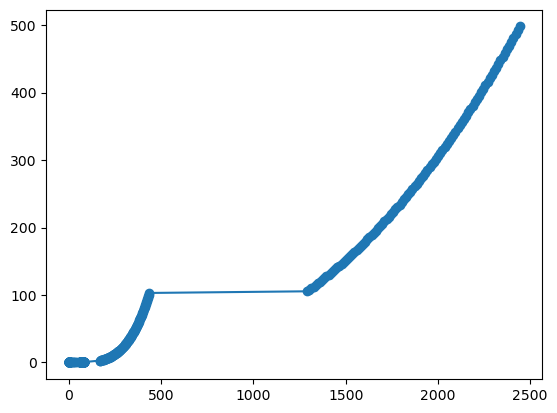

In [6]:
plt.plot(density_dat, pressure_dat, label='EOS')
plt.scatter(density_dat, pressure_dat, label='EOS')

In [7]:
central_energy = np.logspace(np.log10(np.max(density_dat_GU)*0.999),np.log10( 2.072392843084521e-10),50)
#central_energy = np.asarray(central_energy[1])
print(np.max(central_energy), np.min(central_energy),central_energy[4])

3.2161908154870152e-09 2.072392843084521e-10 2.5711531876306645e-09


In [8]:
M= []
R = []
Com = []
Love = []

R,M,Com,Love = TOV_module(central_energy, pressure_dat_GU,density_dat_GU,exit_Pre=np.min(1.1*pressure_dat_GU),love=True,to_print=True)

star  0  done
star  1  done
star  2  done
star  3  done
star  4  done
star  5  done
star  6  done
star  7  done
star  8  done
star  9  done
star  10  done
star  11  done
star  12  done
star  13  done
star  14  done
star  15  done
star  16  done
star  17  done
star  18  done
star  19  done
star  20  done
star  21  done
star  22  done
star  23  done
star  24  done
star  25  done
star  26  done
star  27  done
star  28  done
star  29  done
star  30  done
star  31  done
star  32  done
star  33  done
star  34  done
star  35  done
star  36  done
star  37  done
star  38  done
star  39  done
star  40  done
star  41  done
star  42  done
star  43  done
star  44  done
star  45  done
star  46  done
star  47  done
star  48  done
star  49  done


Text(0, 0.5, 'M/Msun')

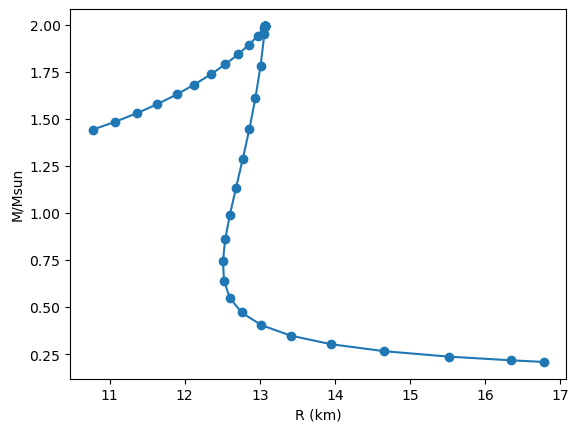

In [9]:
plt.plot(R,M, label='TOV')
plt.scatter(R,M, label='TOV')
plt.xlabel('R (km)')
plt.ylabel('M/Msun')
# plt.xlim(0,20)

In [12]:
def Lambda(k2, C):
    return (2/3)*k2*C**(-5.0)

In [13]:
## For 1.36M and q = 0.73



m1 = np.linspace(1.36,1.65,10)
# q = np.asarray([0.73,0.80,0.87,0.95])
q = np.asarray([0.73,0.75,0.79,0.80,0.82,0.85,0.87,0.90,0.92,0.95])

m2 = m1 * q


print(m2)
print(m1)

radius_from_mass = interp1d(M,R,fill_value='extrapolate')

r1 = radius_from_mass(m1)
r2 = radius_from_mass(m2)

print(r2)

love_from_mass = interp1d(M,Love,fill_value='extrapolate')
Compactness_from_mass = interp1d(M,Com,fill_value='extrapolate')

love1 = love_from_mass(m1)
love2 = love_from_mass(m2)

C1 = Compactness_from_mass(m1)
C2 = Compactness_from_mass(m2)

print(love2)

print(C1, C2)

print('M_TOV = ',np.max(M))
print('R_1.6 = ', radius_from_mass(1.6))

[0.9928     1.04416667 1.12531111 1.16533333 1.22088889 1.29294444
 1.3514     1.427      1.48835556 1.5675    ]
[1.36       1.39222222 1.42444444 1.45666667 1.48888889 1.52111111
 1.55333333 1.58555556 1.61777778 1.65      ]
[12.60281784 12.63220867 12.67863767 12.70195511 12.73445889 12.67205264
 11.93157857 10.97393067 11.10167057 11.57711856]
[0.11059226 0.10934904 0.10738513 0.10593509 0.10376503 0.09826509
 0.0760869  0.04740405 0.04519678 0.05061619]
[0.1716215  0.18164558 0.19166967 0.17478521 0.1976215  0.19824083
 0.19913368 0.19625824 0.18980437 0.20289234] [0.11611486 0.12181591 0.13082192 0.13521171 0.14128822 0.15076103
 0.1689461  0.19246469 0.19761125 0.19956834]
M_TOV =  1.993143524107701
R_1.6 =  12.480616935283347


In [16]:
lam1 = Lambda(love1,C1)
lam2 = Lambda(love2,C2)

print(lam1)
print(lam2)

[326.08065124 204.290789   124.66670602 325.0996031  100.04878464
 103.5164267  105.79949137 134.28034836 200.39498782 106.89634806]
[3492.96617627 2717.71302006 1868.3157559  1562.70500987 1228.65490709
  841.12893185  368.53412777  119.6654932    99.99030316  106.59578578]


In [17]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
from numpy import pi

import bateman as bt
import thermalization as th
import heat as ht
import lightcurve as lc



c = 2.99792458e10
day = 86400.
Msun = 1.9885e33



%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
#fkappa = pd.read_csv('effective_kappa_A141_238.dat',delim_whitespace=True,header=None)
fkappa = pd.read_csv('input_files/effective_kappa_A85_238.dat',delim_whitespace=True,header=None)
#fkappa = pd.read_csv('effective_kappa_141_238.dat',delim_whitespace=True,header=None)

kappa_effs = 0.02*np.ones((240,100))
for i in range(0,len(fkappa)):
    A = fkappa[0][i]
    Z = fkappa[1][i]
    kappa = np.sqrt(fkappa[3][i]*fkappa[4][i])
    kappa_effs[A][Z] = kappa

/var/folders/qf/j495f6rd5_52r4vxvnhky6jr0000gn/T/ipykernel_26211/2689731801.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  fkappa = pd.read_csv('input_files/effective_kappa_A85_238.dat',delim_whitespace=True,header=None)


In [19]:
ffraction = pd.read_csv('input_files/solar_r_abundance_pattern.dat',delim_whitespace=True,header=None)

##########Start input parameters
Amin = 85
Amax = 209


/var/folders/qf/j495f6rd5_52r4vxvnhky6jr0000gn/T/ipykernel_26211/3903697200.py:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  ffraction = pd.read_csv('input_files/solar_r_abundance_pattern.dat',delim_whitespace=True,header=None)


### Changing b1 keeping b2 and b3 parameters fixed

In [1]:

def lightcurve(v,alpha_max,alpha_min,n,kappa_low,kappa_high,be_kappa,m1,m2,lambda1,lambda2,b1,constraint = False):
    import synphot
    from astropy import units as u
    c = 2.99792458e10
    vej = v*c
    # G = 6.67e-8  # Gravitational constant

    # M_thr = G*M_TOV*Msun/(c**2*R*1e5)

    log_ej = (b1*m1*((1/(0.360-0.0355*np.log(lambda1)+0.000705*np.log(lambda1)**2)) - 1)+ 0.2116*m2*(m1/m2)**(-2.905)-2.42/2)+(b1*m2*((1/(0.360-0.0355*np.log(lambda2)+0.000705*np.log(lambda2)**2)) - 1)+ 0.2116*m1*(m2/m1)**(-2.905)-2.42/2)

    M_dyn = 10**(log_ej)*1.9885e33

    # log_M_disc = max(-3,-31.335*(1-0.976*np.arctan((1.0474-(m1+m2)/M_thr)/0.05957)))
    # M_disc = 10**(log_M_disc)*1.9885e33

    Mej = M_dyn # + M_disc


    lamb_t = (16/13)*((m1 + 12 * m2) * (lambda1 * m1**4) + (m2 + 12 * m1) * (lambda2 * m2**4))
    lamb_telda = lamb_t/(m1 + m2)**5


    # print('Calculated {} for mass ratio {}'.format(Mej,(m2/m1)))

    # mass_ej = (-9.335/(0.360-0.0355*np.log(lambda1)+0.000705*np.log(lambda1)**2)+114.17*(m2/m1)**(1.5465)-337.56*(0.360-0.0355*np.log(lambda1)+0.000705*np.log(lambda1)**2))+(-9.335/(0.360-0.0355*np.log(lambda2)+0.000705*np.log(lambda2)**2)+114.17*(m2/m1)**(1.5465)-337.56*(0.360-0.0355*np.log(lambda2)+0.000705*np.log(lambda2)**2))
    # Mej = mass_ej*1.9885e30

    # if Mej < 0:
    #     Mej = 0.0

    if lamb_telda > 800:
        constraint = False




    if constraint == True:
        beta = ht.calc_heating_rate(Mej,vej, Amin,Amax,ffraction,kappa_effs,alpha_max,alpha_min,n)
        heat_time = np.array(beta['t'])
        heat_rate = np.array(beta['electron_th'])+np.array(beta['gamma_th'])

        LC = lc.calc_lightcurve(Mej,vej,alpha_max,alpha_min,n,kappa_low,kappa_high,be_kappa,heat_time, heat_rate)

        # bandpass_labels = 'ubvri'
        # bandpasses = [
        # synphot.SpectralElement.from_filter(f'johnson_{label}')
        # for label in bandpass_labels]
        # seds = [
        # synphot.SourceSpectrum(synphot.BlackBody1D, temperature=TT)
        # * np.pi * (rr / 3.08567758128E+26)**2
        # for TT, rr in zip(LC['T'], LC['R'])]
        # abmags = [
        # [synphot.Observation(sed, bandpass).effstim(u.ABmag).value for sed in seds]
        # for bandpass in bandpasses]

        data = {'t':LC['t'],'LC':LC['LC'],'Temp':LC['T'],'Radius':LC['R'],'q':m2/m1}
    # df = pd.DataFrame(data=data)
    # df.to_csv('output_files/lightcurve.dat',sep=" ",index=False,header=None,columns=['t', 'LC', 'Temp', 'Radius'])

    # from matplotlib import rc
    # rc('text', usetex=False)
    # fig, ax = plt.subplots(figsize=(6.472135955, 4))
    # plt.xlim(0.1,30.)
    # plt.ylim(1.0e39,3.0e42)
    # plt.ylabel(r"$L_{\rm bol}~[{\rm erg/s}]$")
    # plt.xlabel(r"${\rm Time~since~merger~[day]}$")
    # plt.loglog(LC['t'],LC['LC'],label='bolometric',linestyle='-',linewidth=1.5,color='r')
    # plt.title(r'EOS = {EOS} M={M}M$_\odot$ v={v}c'.format(EOS=EOS,M=M,v=v))
    else:
        data = 0


    # plt.legend(loc='lower left',fontsize=14)
    # # plt.savefig("output_files/LC_A85.pdf",dpi=600,bbox_inches='tight')
    # plt.show()

    return data

In [49]:
results = []
for i in range(len(m1)):
    result =lightcurve(0.1,4.0,1.0,4.5,0.5,3.0,0.2,m1[i],m2[i],lam1[i],lam2[i],b1 = -0.0719,constraint=True)
    print('Calculation for q = {} done'.format(m2[i]/m1[i]))
    results.append(result)

results = [i for i in results if i !=0]

Calculation for q = 0.73 done
Calculation for q = 0.75 done


/Users/divyansh/Documents/Research_Projects/Black-Hole-NS-Mass_GAP/Codes/Lightcurve_Code/heat.py:75: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  fchain = pd.read_csv(filename,delim_whitespace=True,header=None)
/Users/divyansh/Documents/Research_Projects/Black-Hole-NS-Mass_GAP/Codes/Lightcurve_Code/heat.py:75: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  fchain = pd.read_csv(filename,delim_whitespace=True,header=None)
/Users/divyansh/Documents/Research_Projects/Black-Hole-NS-Mass_GAP/Codes/Lightcurve_Code/heat.py:75: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  fchain = pd.read_csv(filename,delim_whitespace=True,header=None)
/Users/divyansh/Documents/Research_Projects/Black-Hole-NS-Mass_GAP/Cod

Calculation for q = 0.79 done


/Users/divyansh/Documents/Research_Projects/Black-Hole-NS-Mass_GAP/Codes/Lightcurve_Code/heat.py:75: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  fchain = pd.read_csv(filename,delim_whitespace=True,header=None)
/Users/divyansh/Documents/Research_Projects/Black-Hole-NS-Mass_GAP/Codes/Lightcurve_Code/heat.py:75: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  fchain = pd.read_csv(filename,delim_whitespace=True,header=None)
/Users/divyansh/Documents/Research_Projects/Black-Hole-NS-Mass_GAP/Codes/Lightcurve_Code/heat.py:75: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  fchain = pd.read_csv(filename,delim_whitespace=True,header=None)
/Users/divyansh/Documents/Research_Projects/Black-Hole-NS-Mass_GAP/Cod

Calculation for q = 0.8 done


/Users/divyansh/Documents/Research_Projects/Black-Hole-NS-Mass_GAP/Codes/Lightcurve_Code/heat.py:75: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  fchain = pd.read_csv(filename,delim_whitespace=True,header=None)
/Users/divyansh/Documents/Research_Projects/Black-Hole-NS-Mass_GAP/Codes/Lightcurve_Code/heat.py:75: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  fchain = pd.read_csv(filename,delim_whitespace=True,header=None)
/Users/divyansh/Documents/Research_Projects/Black-Hole-NS-Mass_GAP/Codes/Lightcurve_Code/heat.py:75: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  fchain = pd.read_csv(filename,delim_whitespace=True,header=None)
/Users/divyansh/Documents/Research_Projects/Black-Hole-NS-Mass_GAP/Cod

Calculation for q = 0.82 done


/Users/divyansh/Documents/Research_Projects/Black-Hole-NS-Mass_GAP/Codes/Lightcurve_Code/heat.py:75: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  fchain = pd.read_csv(filename,delim_whitespace=True,header=None)
/Users/divyansh/Documents/Research_Projects/Black-Hole-NS-Mass_GAP/Codes/Lightcurve_Code/heat.py:75: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  fchain = pd.read_csv(filename,delim_whitespace=True,header=None)
/Users/divyansh/Documents/Research_Projects/Black-Hole-NS-Mass_GAP/Codes/Lightcurve_Code/heat.py:75: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  fchain = pd.read_csv(filename,delim_whitespace=True,header=None)
/Users/divyansh/Documents/Research_Projects/Black-Hole-NS-Mass_GAP/Cod

Calculation for q = 0.85 done


/Users/divyansh/Documents/Research_Projects/Black-Hole-NS-Mass_GAP/Codes/Lightcurve_Code/heat.py:75: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  fchain = pd.read_csv(filename,delim_whitespace=True,header=None)
/Users/divyansh/Documents/Research_Projects/Black-Hole-NS-Mass_GAP/Codes/Lightcurve_Code/heat.py:75: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  fchain = pd.read_csv(filename,delim_whitespace=True,header=None)
/Users/divyansh/Documents/Research_Projects/Black-Hole-NS-Mass_GAP/Codes/Lightcurve_Code/heat.py:75: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  fchain = pd.read_csv(filename,delim_whitespace=True,header=None)
/Users/divyansh/Documents/Research_Projects/Black-Hole-NS-Mass_GAP/Cod

Calculation for q = 0.87 done


/Users/divyansh/Documents/Research_Projects/Black-Hole-NS-Mass_GAP/Codes/Lightcurve_Code/heat.py:75: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  fchain = pd.read_csv(filename,delim_whitespace=True,header=None)
/Users/divyansh/Documents/Research_Projects/Black-Hole-NS-Mass_GAP/Codes/Lightcurve_Code/heat.py:75: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  fchain = pd.read_csv(filename,delim_whitespace=True,header=None)
/Users/divyansh/Documents/Research_Projects/Black-Hole-NS-Mass_GAP/Codes/Lightcurve_Code/heat.py:75: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  fchain = pd.read_csv(filename,delim_whitespace=True,header=None)
/Users/divyansh/Documents/Research_Projects/Black-Hole-NS-Mass_GAP/Cod

Calculation for q = 0.9 done


/Users/divyansh/Documents/Research_Projects/Black-Hole-NS-Mass_GAP/Codes/Lightcurve_Code/heat.py:75: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  fchain = pd.read_csv(filename,delim_whitespace=True,header=None)
/Users/divyansh/Documents/Research_Projects/Black-Hole-NS-Mass_GAP/Codes/Lightcurve_Code/heat.py:75: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  fchain = pd.read_csv(filename,delim_whitespace=True,header=None)
/Users/divyansh/Documents/Research_Projects/Black-Hole-NS-Mass_GAP/Codes/Lightcurve_Code/heat.py:75: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  fchain = pd.read_csv(filename,delim_whitespace=True,header=None)
/Users/divyansh/Documents/Research_Projects/Black-Hole-NS-Mass_GAP/Cod

Calculation for q = 0.92 done


/Users/divyansh/Documents/Research_Projects/Black-Hole-NS-Mass_GAP/Codes/Lightcurve_Code/heat.py:75: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  fchain = pd.read_csv(filename,delim_whitespace=True,header=None)
/Users/divyansh/Documents/Research_Projects/Black-Hole-NS-Mass_GAP/Codes/Lightcurve_Code/heat.py:75: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  fchain = pd.read_csv(filename,delim_whitespace=True,header=None)
/Users/divyansh/Documents/Research_Projects/Black-Hole-NS-Mass_GAP/Codes/Lightcurve_Code/heat.py:75: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  fchain = pd.read_csv(filename,delim_whitespace=True,header=None)
/Users/divyansh/Documents/Research_Projects/Black-Hole-NS-Mass_GAP/Cod

Calculation for q = 0.95 done


(1e+39, 1e+42)

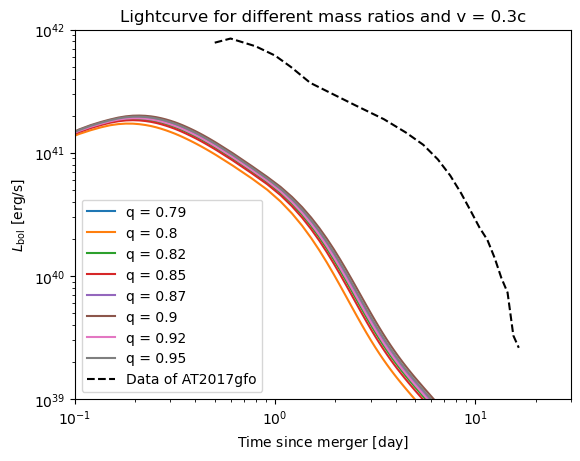

In [50]:
t = [0.5,0.6,0.8,1.0,1.2,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5,10.5,11.5,12.5,13.5,14.5,15.5,16.5]
L_int = [7.82e+41,8.45e+41,7.31e+41,6.15e+41,4.97e+41,3.69e+41,2.44e+41,1.87e+41,1.46e+41,1.16e+41,8.84e+40,6.53e+40,4.69e+40,3.36e+40,2.47e+40,1.96e+40,1.40e+40,9.64e+39,7.33e+39,3.28e+39,2.61e+39]
L_bb = [1.2e+42,1.3e+42,7.0e+41,5.5e+41,4.8e+41,3.6e+41,2.3e+41,1.7e+41,1.4e+41,1.0e+41,9.1e+40,7.0e+40,4.5e+40,2.9e+40,2.0e+40,3.0e+40,3.0e+40,2.1e+40,1.7e+40,7.7e+38,7.7e+38]

for i in range(len(results)):
    plt.loglog(results[i]['t'],results[i]['LC'],label='q = {}'.format(results[i]['q']))
plt.loglog(t,L_int,label='Data of AT2017gfo',linestyle='--',linewidth=1.5,color='black')
#plt.loglog(t,L_bb,label='Data of AT2017gfo',linestyle='--',linewidth=1.5,color='black')
plt.legend()
plt.ylabel(r"$L_{\rm bol}~[{\rm erg/s}]$")
plt.xlabel(r"${\rm Time~since~merger~[day]}$")
plt.title('Lightcurve for different mass ratios and v = 0.3c')
plt.xlim(0.1,30.)
plt.ylim(1.0e39,1.0e42)

# plt.savefig("Fig/lightcurve_v0.3c_HadEOS15.png",dpi=600,bbox_inches='tight')


Calculation for q = 0.73 done
Calculation for q = 0.75 done
Calculation for q = 0.79 done
Calculation for q = 0.8 done
Calculation for q = 0.82 done


/Users/divyansh/Documents/Research_Projects/Black-Hole-NS-Mass_GAP/Codes/Lightcurve_Code/heat.py:75: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  fchain = pd.read_csv(filename,delim_whitespace=True,header=None)
/Users/divyansh/Documents/Research_Projects/Black-Hole-NS-Mass_GAP/Codes/Lightcurve_Code/heat.py:75: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  fchain = pd.read_csv(filename,delim_whitespace=True,header=None)
/Users/divyansh/Documents/Research_Projects/Black-Hole-NS-Mass_GAP/Codes/Lightcurve_Code/heat.py:75: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  fchain = pd.read_csv(filename,delim_whitespace=True,header=None)
/Users/divyansh/Documents/Research_Projects/Black-Hole-NS-Mass_GAP/Cod

Calculation for q = 0.85 done


/Users/divyansh/Documents/Research_Projects/Black-Hole-NS-Mass_GAP/Codes/Lightcurve_Code/heat.py:75: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  fchain = pd.read_csv(filename,delim_whitespace=True,header=None)
/Users/divyansh/Documents/Research_Projects/Black-Hole-NS-Mass_GAP/Codes/Lightcurve_Code/heat.py:75: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  fchain = pd.read_csv(filename,delim_whitespace=True,header=None)
/Users/divyansh/Documents/Research_Projects/Black-Hole-NS-Mass_GAP/Codes/Lightcurve_Code/heat.py:75: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  fchain = pd.read_csv(filename,delim_whitespace=True,header=None)
/Users/divyansh/Documents/Research_Projects/Black-Hole-NS-Mass_GAP/Cod

Calculation for q = 0.87 done


/Users/divyansh/Documents/Research_Projects/Black-Hole-NS-Mass_GAP/Codes/Lightcurve_Code/heat.py:75: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  fchain = pd.read_csv(filename,delim_whitespace=True,header=None)
/Users/divyansh/Documents/Research_Projects/Black-Hole-NS-Mass_GAP/Codes/Lightcurve_Code/heat.py:75: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  fchain = pd.read_csv(filename,delim_whitespace=True,header=None)
/Users/divyansh/Documents/Research_Projects/Black-Hole-NS-Mass_GAP/Codes/Lightcurve_Code/heat.py:75: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  fchain = pd.read_csv(filename,delim_whitespace=True,header=None)
/Users/divyansh/Documents/Research_Projects/Black-Hole-NS-Mass_GAP/Cod

Calculation for q = 0.9 done


/Users/divyansh/Documents/Research_Projects/Black-Hole-NS-Mass_GAP/Codes/Lightcurve_Code/heat.py:75: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  fchain = pd.read_csv(filename,delim_whitespace=True,header=None)
/Users/divyansh/Documents/Research_Projects/Black-Hole-NS-Mass_GAP/Codes/Lightcurve_Code/heat.py:75: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  fchain = pd.read_csv(filename,delim_whitespace=True,header=None)
/Users/divyansh/Documents/Research_Projects/Black-Hole-NS-Mass_GAP/Codes/Lightcurve_Code/heat.py:75: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  fchain = pd.read_csv(filename,delim_whitespace=True,header=None)
/Users/divyansh/Documents/Research_Projects/Black-Hole-NS-Mass_GAP/Cod

Calculation for q = 0.92 done


/Users/divyansh/Documents/Research_Projects/Black-Hole-NS-Mass_GAP/Codes/Lightcurve_Code/heat.py:75: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  fchain = pd.read_csv(filename,delim_whitespace=True,header=None)
/Users/divyansh/Documents/Research_Projects/Black-Hole-NS-Mass_GAP/Codes/Lightcurve_Code/heat.py:75: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  fchain = pd.read_csv(filename,delim_whitespace=True,header=None)
/Users/divyansh/Documents/Research_Projects/Black-Hole-NS-Mass_GAP/Codes/Lightcurve_Code/heat.py:75: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  fchain = pd.read_csv(filename,delim_whitespace=True,header=None)
/Users/divyansh/Documents/Research_Projects/Black-Hole-NS-Mass_GAP/Cod

Calculation for q = 0.95 done


(1e+39, 1e+42)

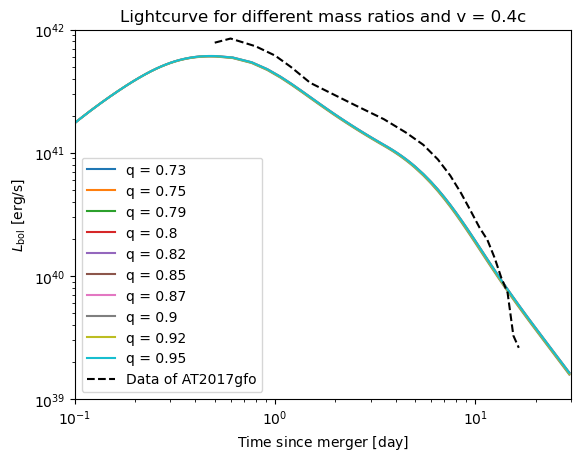

In [ ]:
results1 = []
for i in range(len(m1)):
    result =lightcurve(0.1,4.0,1.0,4.5,0.5,3.0,0.2,m1[i],m2[i],lam1[i],lam2[i],0.02121,constraint=True)
    print('Calculation for q = {} done'.format(m2[i]/m1[i]))
    results1.append(result)

t = [0.5,0.6,0.8,1.0,1.2,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5,10.5,11.5,12.5,13.5,14.5,15.5,16.5]
L_int = [7.82e+41,8.45e+41,7.31e+41,6.15e+41,4.97e+41,3.69e+41,2.44e+41,1.87e+41,1.46e+41,1.16e+41,8.84e+40,6.53e+40,4.69e+40,3.36e+40,2.47e+40,1.96e+40,1.40e+40,9.64e+39,7.33e+39,3.28e+39,2.61e+39]
L_bb = [1.2e+42,1.3e+42,7.0e+41,5.5e+41,4.8e+41,3.6e+41,2.3e+41,1.7e+41,1.4e+41,1.0e+41,9.1e+40,7.0e+40,4.5e+40,2.9e+40,2.0e+40,3.0e+40,3.0e+40,2.1e+40,1.7e+40,7.7e+38,7.7e+38]

for i in range(len(m1)):
    plt.loglog(results1[i]['t'],results1[i]['LC'],label=f'q = {np.round(m2[i]/m1[i],3)}')
plt.loglog(t,L_int,label='Data of AT2017gfo',linestyle='--',linewidth=1.5,color='black')
#plt.loglog(t,L_bb,label='Data of AT2017gfo',linestyle='--',linewidth=1.5,color='black')
plt.legend()
plt.ylabel(r"$L_{\rm bol}~[{\rm erg/s}]$")
plt.xlabel(r"${\rm Time~since~merger~[day]}$")
plt.title('Lightcurve for different mass ratios and v = 0.4c')
plt.xlim(0.1,30.)
plt.ylim(1.0e39,1.0e42)

# plt.savefig("Fig/lightcurve_v0.35c_HadEOS15.png",dpi=600,bbox_inches='tight')

Calculation for q = 0.73 done
Calculation for q = 0.75 done
Calculation for q = 0.79 done
Calculation for q = 0.8 done
Calculation for q = 0.82 done


/Users/divyansh/Documents/Research_Projects/Black-Hole-NS-Mass_GAP/Codes/Lightcurve_Code/heat.py:75: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  fchain = pd.read_csv(filename,delim_whitespace=True,header=None)
/Users/divyansh/Documents/Research_Projects/Black-Hole-NS-Mass_GAP/Codes/Lightcurve_Code/heat.py:75: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  fchain = pd.read_csv(filename,delim_whitespace=True,header=None)
/Users/divyansh/Documents/Research_Projects/Black-Hole-NS-Mass_GAP/Codes/Lightcurve_Code/heat.py:75: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  fchain = pd.read_csv(filename,delim_whitespace=True,header=None)
/Users/divyansh/Documents/Research_Projects/Black-Hole-NS-Mass_GAP/Cod

Calculation for q = 0.85 done


/Users/divyansh/Documents/Research_Projects/Black-Hole-NS-Mass_GAP/Codes/Lightcurve_Code/heat.py:75: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  fchain = pd.read_csv(filename,delim_whitespace=True,header=None)
/Users/divyansh/Documents/Research_Projects/Black-Hole-NS-Mass_GAP/Codes/Lightcurve_Code/heat.py:75: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  fchain = pd.read_csv(filename,delim_whitespace=True,header=None)
/Users/divyansh/Documents/Research_Projects/Black-Hole-NS-Mass_GAP/Codes/Lightcurve_Code/heat.py:75: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  fchain = pd.read_csv(filename,delim_whitespace=True,header=None)
/Users/divyansh/Documents/Research_Projects/Black-Hole-NS-Mass_GAP/Cod

Calculation for q = 0.87 done


/Users/divyansh/Documents/Research_Projects/Black-Hole-NS-Mass_GAP/Codes/Lightcurve_Code/heat.py:75: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  fchain = pd.read_csv(filename,delim_whitespace=True,header=None)
/Users/divyansh/Documents/Research_Projects/Black-Hole-NS-Mass_GAP/Codes/Lightcurve_Code/heat.py:75: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  fchain = pd.read_csv(filename,delim_whitespace=True,header=None)
/Users/divyansh/Documents/Research_Projects/Black-Hole-NS-Mass_GAP/Codes/Lightcurve_Code/heat.py:75: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  fchain = pd.read_csv(filename,delim_whitespace=True,header=None)
/Users/divyansh/Documents/Research_Projects/Black-Hole-NS-Mass_GAP/Cod

Calculation for q = 0.9 done


/Users/divyansh/Documents/Research_Projects/Black-Hole-NS-Mass_GAP/Codes/Lightcurve_Code/heat.py:75: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  fchain = pd.read_csv(filename,delim_whitespace=True,header=None)
/Users/divyansh/Documents/Research_Projects/Black-Hole-NS-Mass_GAP/Codes/Lightcurve_Code/heat.py:75: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  fchain = pd.read_csv(filename,delim_whitespace=True,header=None)
/Users/divyansh/Documents/Research_Projects/Black-Hole-NS-Mass_GAP/Codes/Lightcurve_Code/heat.py:75: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  fchain = pd.read_csv(filename,delim_whitespace=True,header=None)
/Users/divyansh/Documents/Research_Projects/Black-Hole-NS-Mass_GAP/Cod

Calculation for q = 0.92 done


/Users/divyansh/Documents/Research_Projects/Black-Hole-NS-Mass_GAP/Codes/Lightcurve_Code/heat.py:75: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  fchain = pd.read_csv(filename,delim_whitespace=True,header=None)
/Users/divyansh/Documents/Research_Projects/Black-Hole-NS-Mass_GAP/Codes/Lightcurve_Code/heat.py:75: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  fchain = pd.read_csv(filename,delim_whitespace=True,header=None)
/Users/divyansh/Documents/Research_Projects/Black-Hole-NS-Mass_GAP/Codes/Lightcurve_Code/heat.py:75: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  fchain = pd.read_csv(filename,delim_whitespace=True,header=None)
/Users/divyansh/Documents/Research_Projects/Black-Hole-NS-Mass_GAP/Cod

Calculation for q = 0.95 done


(1e+39, 1e+42)

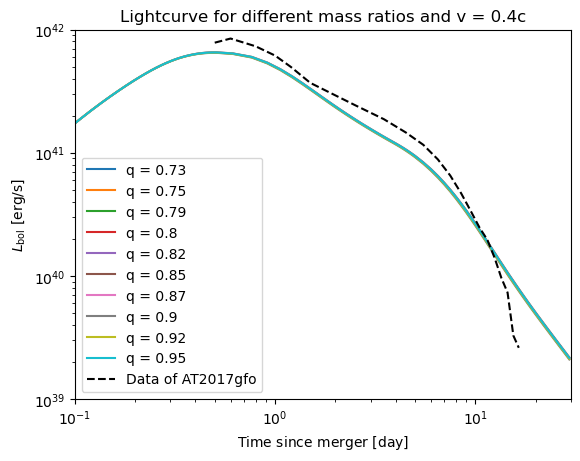

In [ ]:
results2 = []
for i in range(len(m1)):
    result =lightcurve(0.1,4.0,1.0,4.5,0.5,3.0,0.2,m1[i],m2[i],lam1[i],lam2[i],0.02727,constraint=True)
    print('Calculation for q = {} done'.format(m2[i]/m1[i]))
    results2.append(result)

t = [0.5,0.6,0.8,1.0,1.2,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5,10.5,11.5,12.5,13.5,14.5,15.5,16.5]
L_int = [7.82e+41,8.45e+41,7.31e+41,6.15e+41,4.97e+41,3.69e+41,2.44e+41,1.87e+41,1.46e+41,1.16e+41,8.84e+40,6.53e+40,4.69e+40,3.36e+40,2.47e+40,1.96e+40,1.40e+40,9.64e+39,7.33e+39,3.28e+39,2.61e+39]
L_bb = [1.2e+42,1.3e+42,7.0e+41,5.5e+41,4.8e+41,3.6e+41,2.3e+41,1.7e+41,1.4e+41,1.0e+41,9.1e+40,7.0e+40,4.5e+40,2.9e+40,2.0e+40,3.0e+40,3.0e+40,2.1e+40,1.7e+40,7.7e+38,7.7e+38]

for i in range(len(m1)):
    plt.loglog(results2[i]['t'],results2[i]['LC'],label=f'q = {np.round(m2[i]/m1[i],3)}')
plt.loglog(t,L_int,label='Data of AT2017gfo',linestyle='--',linewidth=1.5,color='black')
#plt.loglog(t,L_bb,label='Data of AT2017gfo',linestyle='--',linewidth=1.5,color='black')
plt.legend()
plt.ylabel(r"$L_{\rm bol}~[{\rm erg/s}]$")
plt.xlabel(r"${\rm Time~since~merger~[day]}$")
plt.title('Lightcurve for different mass ratios and v = 0.4c')
plt.xlim(0.1,30.)
plt.ylim(1.0e39,1.0e42)

# plt.savefig("Fig/lightcurve_v0.25c_HadEOS15.png",dpi=600,bbox_inches='tight')

Calculation for q = 0.73 done
Calculation for q = 0.75 done
Calculation for q = 0.79 done
Calculation for q = 0.8 done
Calculation for q = 0.82 done
Calculation for q = 0.85 done
Calculation for q = 0.87 done


/Users/divyansh/Documents/Research_Projects/Black-Hole-NS-Mass_GAP/Codes/Lightcurve_Code/heat.py:75: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  fchain = pd.read_csv(filename,delim_whitespace=True,header=None)
/Users/divyansh/Documents/Research_Projects/Black-Hole-NS-Mass_GAP/Codes/Lightcurve_Code/heat.py:75: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  fchain = pd.read_csv(filename,delim_whitespace=True,header=None)
/Users/divyansh/Documents/Research_Projects/Black-Hole-NS-Mass_GAP/Codes/Lightcurve_Code/heat.py:75: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  fchain = pd.read_csv(filename,delim_whitespace=True,header=None)
/Users/divyansh/Documents/Research_Projects/Black-Hole-NS-Mass_GAP/Cod

Calculation for q = 0.9 done


/Users/divyansh/Documents/Research_Projects/Black-Hole-NS-Mass_GAP/Codes/Lightcurve_Code/heat.py:75: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  fchain = pd.read_csv(filename,delim_whitespace=True,header=None)
/Users/divyansh/Documents/Research_Projects/Black-Hole-NS-Mass_GAP/Codes/Lightcurve_Code/heat.py:75: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  fchain = pd.read_csv(filename,delim_whitespace=True,header=None)
/Users/divyansh/Documents/Research_Projects/Black-Hole-NS-Mass_GAP/Codes/Lightcurve_Code/heat.py:75: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  fchain = pd.read_csv(filename,delim_whitespace=True,header=None)
/Users/divyansh/Documents/Research_Projects/Black-Hole-NS-Mass_GAP/Cod

Calculation for q = 0.92 done


/Users/divyansh/Documents/Research_Projects/Black-Hole-NS-Mass_GAP/Codes/Lightcurve_Code/heat.py:75: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  fchain = pd.read_csv(filename,delim_whitespace=True,header=None)
/Users/divyansh/Documents/Research_Projects/Black-Hole-NS-Mass_GAP/Codes/Lightcurve_Code/heat.py:75: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  fchain = pd.read_csv(filename,delim_whitespace=True,header=None)
/Users/divyansh/Documents/Research_Projects/Black-Hole-NS-Mass_GAP/Codes/Lightcurve_Code/heat.py:75: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  fchain = pd.read_csv(filename,delim_whitespace=True,header=None)
/Users/divyansh/Documents/Research_Projects/Black-Hole-NS-Mass_GAP/Cod

Calculation for q = 0.95 done


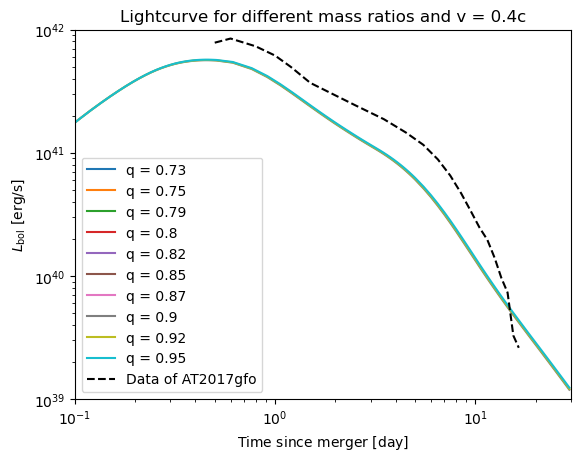

In [ ]:
results3 = []
for i in range(len(m1)):
    result =lightcurve(0.1,4.0,1.0,4.5,0.5,3.0,0.2,m1[i],m2[i],lam1[i],lam2[i],np.max(M),radius_from_mass(1.6),constraint=True)
    print('Calculation for q = {} done'.format(m2[i]/m1[i]))
    results3.append(result)

t = [0.5,0.6,0.8,1.0,1.2,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5,10.5,11.5,12.5,13.5,14.5,15.5,16.5]
L_int = [7.82e+41,8.45e+41,7.31e+41,6.15e+41,4.97e+41,3.69e+41,2.44e+41,1.87e+41,1.46e+41,1.16e+41,8.84e+40,6.53e+40,4.69e+40,3.36e+40,2.47e+40,1.96e+40,1.40e+40,9.64e+39,7.33e+39,3.28e+39,2.61e+39]
L_bb = [1.2e+42,1.3e+42,7.0e+41,5.5e+41,4.8e+41,3.6e+41,2.3e+41,1.7e+41,1.4e+41,1.0e+41,9.1e+40,7.0e+40,4.5e+40,2.9e+40,2.0e+40,3.0e+40,3.0e+40,2.1e+40,1.7e+40,7.7e+38,7.7e+38]

for i in range(len(m1)):
    plt.loglog(results3[i]['t'],results3[i]['LC'],label=f'q = {np.round(m2[i]/m1[i],3)}')
plt.loglog(t,L_int,label='Data of AT2017gfo',linestyle='--',linewidth=1.5,color='black')
#plt.loglog(t,L_bb,label='Data of AT2017gfo',linestyle='--',linewidth=1.5,color='black')
plt.legend()
plt.ylabel(r"$L_{\rm bol}~[{\rm erg/s}]$")
plt.xlabel(r"${\rm Time~since~merger~[day]}$")
plt.title('Lightcurve for different mass ratios and v = 0.4c')
plt.xlim(0.1,30.)
plt.ylim(1.0e39,1.0e42)

plt.savefig("Fig/lightcurve_v0.4c_HadEOS15.png",dpi=600,bbox_inches='tight')